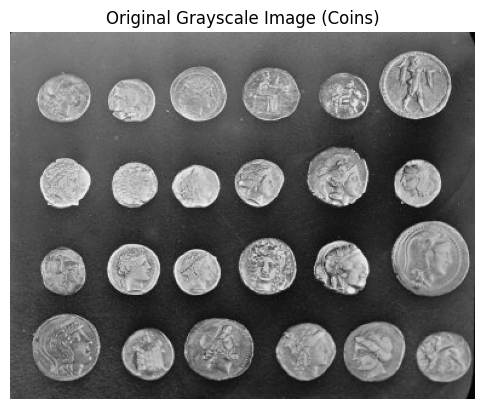

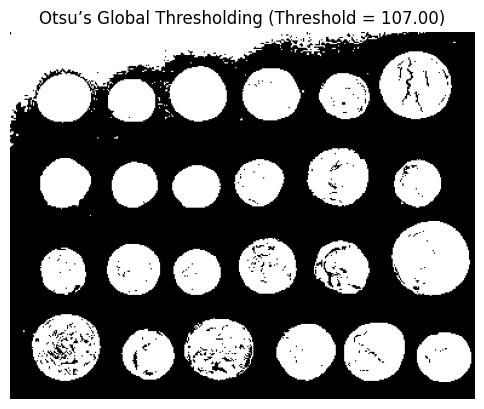

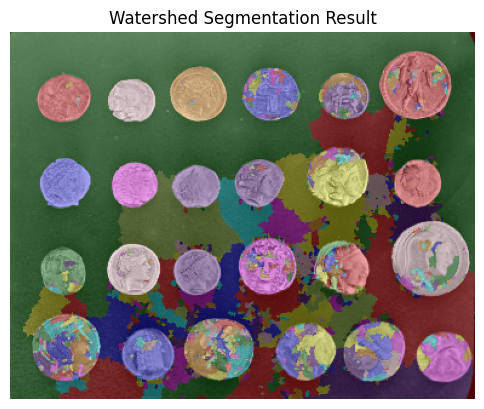

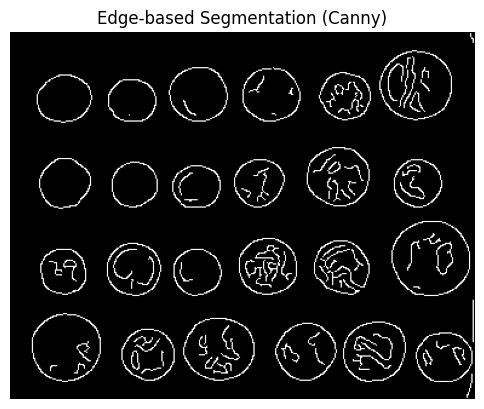

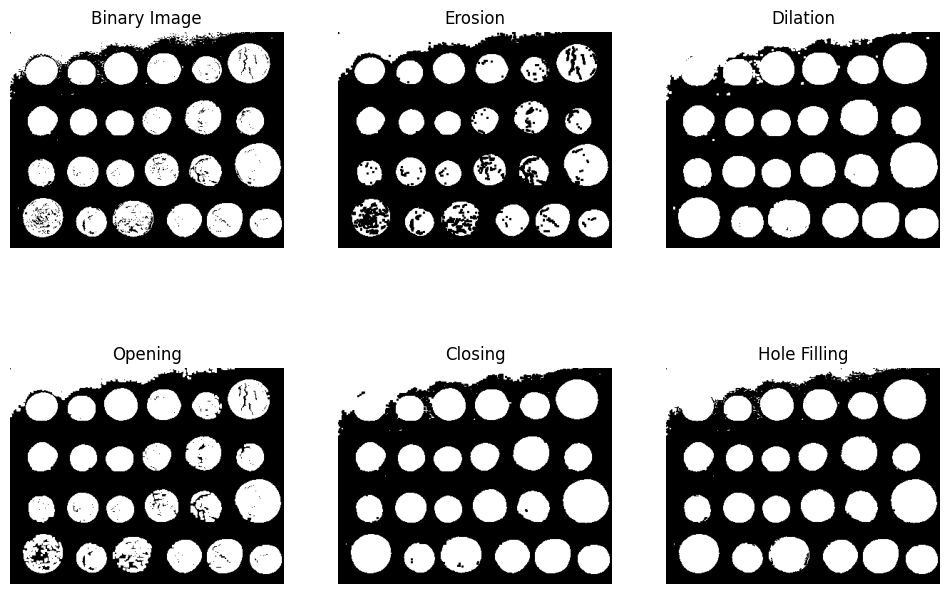

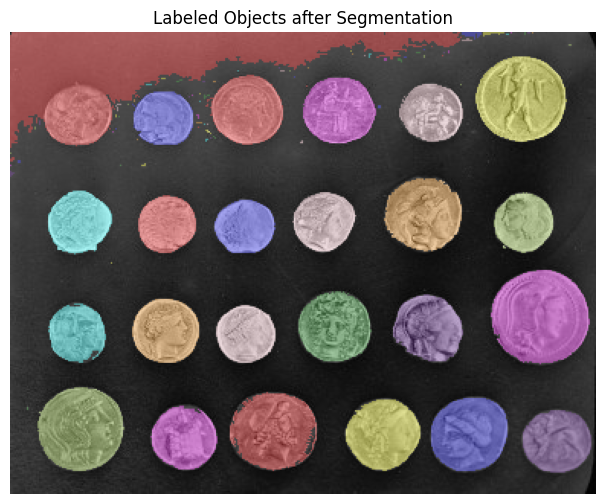

Label Area      Perimeter   Centroid                 Orientation    Eccentricity   
-------------------------------------------------------------------------------------
1     9076.00   929.04      [22.96 91.35]            -1.42          0.98           
2     37.00     27.04       [  1.08 302.19]          1.52           0.96           
3     21.00     19.41       [  0.38 315.29]          -1.51          0.99           
4     1.00      0.00        [  0. 328.]              -0.79          0.00           
5     2.00      0.00        [  0.5 337. ]            0.00           1.00           
6     2.00      0.00        [  0.  339.5]            1.57           1.00           
7     1.00      0.00        [  0. 342.]              -0.79          0.00           
8     2.00      0.00        [  1.  325.5]            1.57           1.00           
9     9.00      7.00        [  4.78 299.11]          -1.54          0.97           
10    2.00      0.00        [  8.  366.5]            1.57           1.00  

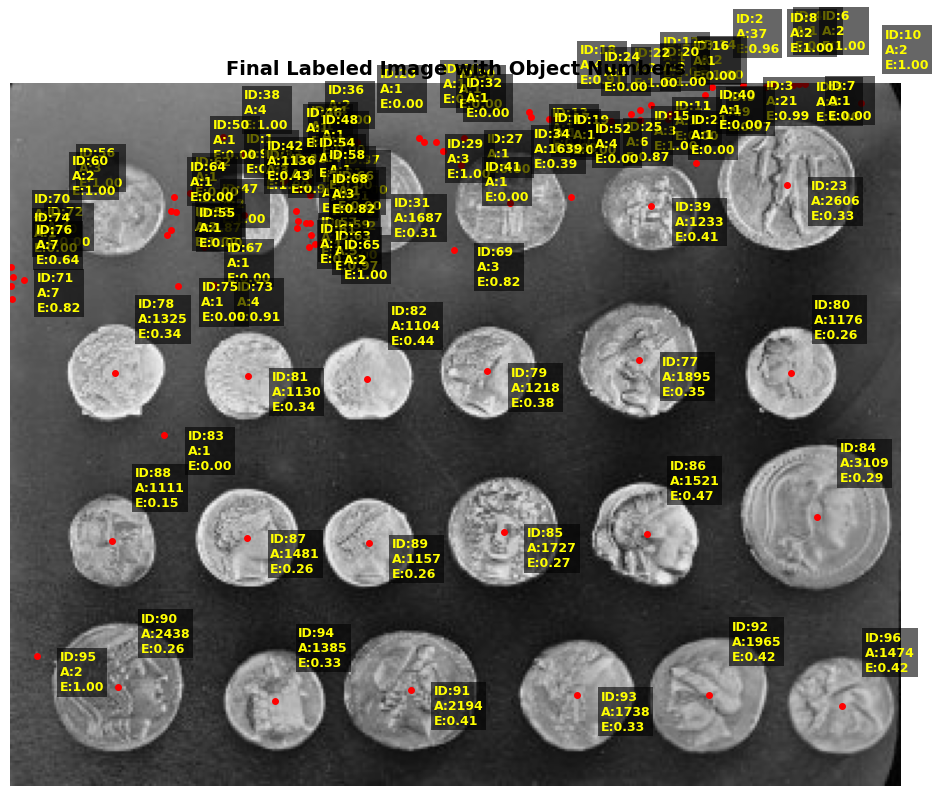

In [8]:
# ===============================
# DIGITAL IMAGE PROCESSING - ASSIGNMENT 2
# IMAGE SEGMENTATION & FEATURE EXTRACTION
# ===============================

# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, measure, morphology, segmentation, color, feature
from scipy import ndimage as ndi

# -----------------------------
# 1. Load Image
# -----------------------------
# Use sample coins image from skimage
image = data.coins()

plt.figure(figsize=(6,6))
plt.title("Original Grayscale Image (Coins)")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# -----------------------------
# 2(a). Global Thresholding (Otsu’s method)
# -----------------------------
thresh_val = filters.threshold_otsu(image)
binary_otsu = image > thresh_val

plt.figure(figsize=(6,6))
plt.title(f"Otsu’s Global Thresholding (Threshold = {thresh_val:.2f})")
plt.imshow(binary_otsu, cmap='gray')
plt.axis('off')
plt.show()

# -----------------------------
# 2(b). Watershed Segmentation
# -----------------------------
# Compute gradient for watershed
gradient = filters.sobel(image)

# Create markers for watershed
markers = ndi.label(image < 30)[0] + ndi.label(image > 150)[0]
ws_labels = segmentation.watershed(gradient, markers)

plt.figure(figsize=(6,6))
plt.title("Watershed Segmentation Result")
plt.imshow(color.label2rgb(ws_labels, image=image, bg_label=0))
plt.axis('off')
plt.show()

# -----------------------------
# 2(c). Edge-based Segmentation (Canny)
# -----------------------------
edges = feature.canny(image, sigma=2)

plt.figure(figsize=(6,6))
plt.title("Edge-based Segmentation (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

# -----------------------------
# 2(d). Morphological Operations
# -----------------------------
# Convert Otsu’s result to uint8
binary = np.uint8(binary_otsu)

kernel = np.ones((3,3), np.uint8)

# Erosion
eroded = cv2.erode(binary, kernel, iterations=1)

# Dilation
dilated = cv2.dilate(binary, kernel, iterations=1)

# Opening and Closing
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Boundary extraction
boundary = cv2.subtract(dilated, eroded)

# Hole filling
filled = ndi.binary_fill_holes(binary)

# Display results
fig, ax = plt.subplots(2, 3, figsize=(12,8))
ax[0,0].imshow(binary, cmap='gray'); ax[0,0].set_title("Binary Image")
ax[0,1].imshow(eroded, cmap='gray'); ax[0,1].set_title("Erosion")
ax[0,2].imshow(dilated, cmap='gray'); ax[0,2].set_title("Dilation")
ax[1,0].imshow(opened, cmap='gray'); ax[1,0].set_title("Opening")
ax[1,1].imshow(closed, cmap='gray'); ax[1,1].set_title("Closing")
ax[1,2].imshow(filled, cmap='gray'); ax[1,2].set_title("Hole Filling")
for a in ax.ravel(): a.axis('off')
plt.show()

# -----------------------------
# 3. Labeling and Feature Extraction
# -----------------------------
# Label connected components
labeled_img = measure.label(filled)
props = measure.regionprops(labeled_img)

# Display labeled image
plt.figure(figsize=(8,6))
plt.imshow(color.label2rgb(labeled_img, image=image, bg_label=0))
plt.title("Labeled Objects after Segmentation")
plt.axis('off')
plt.show()

# Create a table of object features
print(f"{'Label':<6}{'Area':<10}{'Perimeter':<12}{'Centroid':<25}{'Orientation':<15}{'Eccentricity':<15}")
print("-"*85)
for i, region in enumerate(props):
    print(f"{i+1:<6}{region.area:<10.2f}{region.perimeter:<12.2f}{str(np.round(region.centroid,2)):<25}{region.orientation:<15.2f}{region.eccentricity:<15.2f}")

# -----------------------------
# 4. Final Labeled Visualization with Metrics (Clean Version)
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image, cmap='gray')
ax.set_title("Final Labeled Image with Object Numbers", fontsize=14, weight='bold')
ax.axis('off')

# Control label spacing
label_offset = 15  # distance between text and centroid

for i, region in enumerate(props):
    y, x = region.centroid

    # Alternate offset direction to avoid overlapping
    dy = (-1)**i * label_offset

    # Draw centroid marker
    ax.plot(x, y, 'r.', markersize=8)

    # Create text with metrics
    label_text = (f"ID:{region.label}\n"
                  f"A:{int(region.area)}\n"
                  f"E:{region.eccentricity:.2f}")

    # Add text with offset and styling
    ax.text(x + 10, y + dy, label_text,
            color='yellow', fontsize=9, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.6, pad=2, edgecolor='none'))

plt.tight_layout()
plt.show()

